### Organized dataset analysis
Data that Lingyan shared and I got access to in October

Data Lingyan shared: https://drive.google.com/drive/folders/1-MVk-mxI7Vg-68OB3QcOBMCXO8Iqy1cU

The betas data is in the freq_ap folder and in my laptop, it is located in: /Users/add8/Documents/Multisensory_lab/Data_betas

The data for the subject 02 is called FreqAP02 and then, the filename ends in _f1.txt or _f2.txt

In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import time

from scipy.stats import multivariate_normal, pearsonr, ttest_ind, ttest_1samp, norm
from scipy.optimize import curve_fit

In [2]:
# Functions from V2_does_within_condition_model_performance_differ_across_conditions_noise_floor

# make channel basis functions
# channelResponse C, [nxk]
# channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli, nFolds)

def create_channel_basis(nChannels = 9, exponent = 7, nStimuli = 9):
    # Note in this case, the number of channels is the same as the number of stimuli.

    frequency_range = np.arange(100, 341)
    tactile_stimuli = [i*30+100 for i in range(nStimuli)]
    
    channelBasis = np.zeros((241, nChannels)) # ideal channel responses to each of 210 frequencies
    
    # Creates the channel basis
    for iChannel in range(nChannels):
        # The output of this channel basis might be something different than expected.
        thisChannelBasis =  np.cos(2*np.pi*(frequency_range-tactile_stimuli[iChannel])/360)
        # rectify
        thisChannelBasis[thisChannelBasis<0] = 0
        thisChannelBasis = thisChannelBasis**exponent
        channelBasis[:,iChannel] = thisChannelBasis
        
    # Computes the channelResponse for each stimuli
    C = np.zeros((nStimuli, nChannels))
    
    for iStim in range(nStimuli):
        C[iStim, :] = channelBasis[tactile_stimuli[iStim]-100,:]
        
    return channelBasis, C


# Implementing the inverted encoding model
# Inputs: channelResponse, voxelResponse
def model_fit(C, B_train):
        
    W_estimated = np.matmul(np.linalg.pinv(C), B_train) # Computes the (Moore-Penrose) pseudo-inverse of C1
    B_predicted = np.matmul(C, W_estimated) # model prediction on test data
    
    return W_estimated, B_predicted


# voxelResponse B, [nxv]
# channelResponse C, [nxk]
# Note: channelBasis != channelResponse. The channelResponse is C.

def likelihoods_from_already_trained_model(B_predicted, B_test, nVoxels):
    
    nfrequencies = 241
    nTestTrials = 9
    
    # compute residual
    residualResponse = B_test - B_predicted
    residualVariance = np.var(residualResponse) # a scalar value
#     print("Residual variance",residualVariance) # Note: When using random BOLD values, this turns out very small

    # compute r2 for the decoded model. Jeff: Model performance that is not cross-validated.
    r2 = 1 - residualVariance / np.var(B_test)
    
    # Diagonal elements of the matrix are the variance computed across all voxels.
    # Off diagonals (in this case all 0) contain covariance between voxels
    modelCovar = np.identity(nVoxels) * residualVariance
    
    # cycle over each trial
    nTestTrials = np.size(B_test, 0) # n-t
    likelihood = np.zeros([nTestTrials, nfrequencies]) # n-t, 241
    probability = np.zeros([nTestTrials, nfrequencies]) #normalized_likelihood

    for iTrial in range(nTestTrials):

        for iStimulus in range(nfrequencies):
            # compute the mean voxel response predicted by the channel encoding model
            # For the same stimulus, B_predicted is always the same.
            B_every_freq = np.matmul(channelBasis[iStimulus], W_estimated) # 1 X v-voxels
            # The probability of a stimulis is given by the mean response and the model covariance.

            # HERE!! Jeff: the predictedResponse can be expanded in the domain.
            mvnpdf = multivariate_normal.pdf(B_test[iTrial], mean=B_every_freq, cov = modelCovar)
            likelihood[iTrial,iStimulus] = mvnpdf
            
    # Obtaining probability vector, aka normalizing likelihood across trials
    for trial_i in range(nTestTrials):

        upper_lim = max(likelihood[trial_i,:])
        lower_lim = min(likelihood[trial_i,:])

        # Normalization of the likelihood. It is undefined when: upper_lim = lower_lim
        probability[trial_i,:] = (likelihood[trial_i,:]-lower_lim) / (upper_lim-lower_lim)

    
    return r2, likelihood, probability

# Used to fit a gaussian to each trial.
def gaussian(x, mu, sigma, amplitude):
    coefficient = amplitude/ np.sqrt(2*np.pi*sigma**2)
    return coefficient*np.exp(-(x-mu)**2/(2*sigma**2))

# Function that given a vector, replicates the first 50 and last 50 entries of the array.
# The vector should be at least length 100
# Used as a supplementary to `curve_fit`
def mirror_edges(vector, cushion=10):
    
    length = len(vector)
    
    if length < cushion*2:
        print("Vector less than 100 entries")
        
    else:
        beginning = np.flip(vector[0:cushion])
        ending = np.flip(vector[length-cushion:length])
        
    return np.concatenate((beginning, vector, ending))


# Inputs nfrequencies
def gaussian_fit(probability, cushion = 10):

    # Fitting a gaussian to all the test trials
    nTestTrials, nfrequencies = probability.shape

    xdata = [i-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310
    xdata_real = [i+100-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310

    means_vec = np.zeros(nTestTrials)
    sigmas_vec = np.zeros(nTestTrials)
    amplitudes_vec = np.zeros(nTestTrials)

    for trial_i in range(nTestTrials): # 90 iterations. THESE INDICES SHOULD SPAN THE ACTUAL SPACE
        ydata = probability[trial_i, :]
        ydata_mirror = mirror_edges(probability[trial_i,:]) # CONCATENATED VECTOR IN THE EDGES.
        # Jeff Note: mirroring the probability in the edges destroys the noise effects

        p0 = [probability[trial_i,:].argmax(), 0.5, 1] # initial guess

        try:
            # Using non-lionear least squares to fit the data
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
            fit_gauss = curve_fit(gaussian, xdata, ydata_mirror, p0)
            # gaussian takes: x, mu, sigma, amplitude
        except RuntimeError:
            print("Error fitting gaussian in: ",trial_i)
            fit_gauss = [['nan', 'nan', 'nan']]

        means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i] = fit_gauss[0]

    return means_vec, sigmas_vec, amplitudes_vec


# Function that obtains the relative distance between the values xx and yy, i.e. a divergence function.
# The relative error is pondered by the interval of maximum and minimum values vary across the 2 folds.
# xx and yy are 1-dimensional vectors with 9 entries (frequencies)
def relative_error(xx, yy):
    all_entries = np.concatenate((xx, yy))
    
    maximum = np.max(all_entries)
    minimum = np.min(all_entries)
    
    relative_error = [np.abs(xx[i]-yy[i])/(maximum-minimum) for i in range(len(xx))]    
    
    return np.mean(relative_error)


# Given 2 folds of the data and some exclusion criteria,
# finds the voxels that meet this criteria.
def mask_creation(m1, m2, exclusion_criteria_pearson = 0.7, exclusion_criteria_relative = 0.8):

    length = m1.shape[0]

    absolute_err_vec = [np.mean(np.abs(m1[i] - m2[i])) for i in range(length)]
    absolute_err_1_vec = [1-np.mean(np.abs(m1[i] - m2[i])) for i in range(m1.shape[0])]
    relative_err_vec = [relative_error(m1[i], m2[i]) for i in range(length)]
    relative_err_1_vec = [1-(relative_err_vec[i]) for i in range(length)]
    pearson_cross_correlation = [pearsonr(m1[i], m2[i])[0] for i in range(length)]

    indices_pearson = []
    indices_relative = []
    indices_both = []

    mask_both = [False for i in range(length)]
    mask_pearson_only = [False for i in range(length)]
    mask_relative_only = [False for i in range(length)]

    for i in range(length):

        if pearson_cross_correlation[i] > exclusion_criteria_pearson: # voxel is included in mask_both or mask_pearson_only
            indices_pearson.append(i)

            if relative_err_1_vec[i] > exclusion_criteria_relative: # voxel meets both criteria.
                indices_relative.append(i)
                indices_both.append(i)
                mask_both[i] = True

            else: # voxel only meets Pearson criteria.
                mask_pearson_only[i] = True

        if relative_err_1_vec[i] > exclusion_criteria_relative: # voxel is not considered in a traditional analysis!
            indices_relative.append(i)
            mask_relative_only[i] = True

    print("Number of included voxels that meet both criteria:",len(indices_both))

    return mask_both


# Function that obtains the relative distance between the values xx and yy, i.e. a divergence function.
# The relative error is pondered by the interval of maximum and minimum values vary across the 2 folds.
# xx and yy are 1-dimensional vectors with 9 entries (frequencies)
def relative_error(xx, yy):
    all_entries = np.concatenate((xx, yy))
    
    maximum = np.max(all_entries)
    minimum = np.min(all_entries)
    
    relative_error = [np.abs(xx[i]-yy[i])/(maximum-minimum) for i in range(len(xx))]    
    
    return np.mean(relative_error)


# Gaussian function for fitting the null distribution
def gaussian_null_dist(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

In [3]:
def simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency):
    # Running the simulation
    start_time = time.time()
    # How much time is this taking to run? https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution

    C_estimated = np.matmul(B_test, np.linalg.pinv(W_estimated)) # estimated channel responses from B2
    r2, likelihood, probability = likelihoods_from_already_trained_model(B_predicted, B_test, nVoxels)

    means_vec, sigmas_vec, amplitudes_vec = gaussian_fit(probability, cushion = 10)
#     print("Gaussian fit ready.")

    # Mean absolute error in Hz
    tactile_stimuli = np.asarray([i*30+100 for i in range(nStimuli)])
    error_Hz_vec = np.abs(tactile_stimuli-(means_vec+initial_frequency))

    # Normalized relative error, each frequency is weighted differently depending on the maximum error possible of the decoder on that frequency
#     max_error_vec = [  240.,  210.,  180.,  150., 120., 150., 180., 210., 240.]
    
#     error_vec_Hz = np.abs(tactile_stimuli-means_vec)
#     error_vec_common_space_across_frequencies = np.asarray([error_vec_Hz[i]/max_error_vec[i] for i in range(nStimuli)])
#     # print(error_vec_common_space_across_frequencies)
#     error_scalar_normalized_space = np.mean(error_vec_common_space_across_frequencies)

    simulation_time = time.time() - start_time

    print("--- %s seconds ---" % simulation_time) # Converts any value into a string.
    
    return C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec

In [4]:
def initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec):
    # Obtain the similarity plot
    nTrials = B.shape[0]
    matrix = np.zeros([nTrials, nTrials])

    for i in range(nTrials):
        for j in range(nTrials):
            matrix[i, j] = pearsonr(B[i,:], B[j,:])[0]    
            
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(matrix)
    plt.show()

    # I expect to see 9 peaks in this graph.
    plt.plot(C_estimated)
    plt.xlabel('n-stimuli')
    plt.ylabel('Channel response')
    plt.title('Estimated Channel Response') # [B2 * W_estimated^T] = n-t * k
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.imshow(probability)
    plt.xlabel('Stimulus frequency -100 [Hz]')
    plt.ylabel('Ordered trial #')
    plt.title('Probability')
    plt.show()
    
    # # Decoding Model Accuracy and Estimated Channel Responses
    #Neural noise is between 0.4 and 0.5 in the model we were playing with to replicate
    #this level of r^2 decoding accuracy (see notes Thu, Sep 12).
    print("Model performance that is not cross-validated",r2)
    
    plt.plot(means_vec)
    plt.title("Means")
    plt.xlabel('Trial #')
    plt.ylabel('Gaussian mean (most likely orientation [deg])')
    plt.show()

    plt.plot(sigmas_vec)
    plt.title("Sigmas")
    plt.xlabel('Trial #')
    plt.ylabel('Gaussian stdev (most likely sigma)')
    plt.show()

    plt.plot(amplitudes_vec)
    plt.title("Amplitude")
    plt.xlabel('Trial #')
    plt.ylabel('Gaussian amplitude (most likely amplitude)')
    plt.show()

    # In the 340 Hz trials, the sigmas have higher values.
    # This might be related to the estimatedChannelResponses?
    #The lower sigmas for 100 and 310 Hz might be some kind of border effect?
    return None


def other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition):

#     plt.scatter(tactile_stimuli, sigmas_vec, c="k")
#     plt.hlines(np.mean(sigmas_vec), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
#                linestyle='dashed', colors = 'r')
#     plt.ylabel("Sigma (from gaussian fit)")
#     plt.xlabel('Trial #')
#     plt.title('Mean sigma (from gaussian fit) '+str(np.round(np.mean(sigmas_vec), 2)))
#     plt.show()

    trials = [i for i in range(9)]
    all_freq_stimuli = [i+initial_frequency for i in range(241)]
    xdata = [i for i in range(241)]

    for trial_i in range(len(trials)):

        mean, sigma, amplitude = means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i]
        label_Hz = str(round(mean) + initial_frequency)

        plt.plot(all_freq_stimuli, probability[trial_i,:], marker=".", c="k")
        plt.plot(all_freq_stimuli, gaussian(xdata, mean, sigma, amplitude),  label=label_Hz)

        plt.title("Gaussians for all the trials")
        plt.xlabel('Stimulus frequency [Hz]')
        plt.ylabel('Likelihood')
        plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5), title="Frequencies [Hz]")

    plt.show()

    # Calculating the error of the fitted gaussian's mean compared to the real frequency.
    plt.scatter(tactile_stimuli, average_error_per_condition, c="k")#, label=label_Hz)
    plt.hlines(np.mean(average_error_per_condition), tactile_stimuli[0], tactile_stimuli[len(tactile_stimuli)-1],
               linestyle='dashed', colors = 'r')
    plt.xlabel(r'Decoded Frequency [Hz]')
    plt.ylabel(r'Average error per condition')    
    plt.title("Mean Error "+str(np.round(np.mean(average_error_per_condition), 2)))
    plt.show()

    return None

In [5]:
# # All the data from the previous dataset is here!
# subj = 'Data_betas/Betas/FreqAP02'
# hand = 'L'
# # vox1 = np.load(subj+'_N1L1.npy')
# # vox2 = np.load(subj+'_N1L2.npy')

# matrix1 = np.load(subj+'_N1L1.npy')
# matrix2 = np.load(subj+'_N1L2.npy')

How do I extract all the voxels for all the regions of patient 2?
Perhaps it would be easier to extract these with an object, the object could have a property called `all_voxels`.

How do I obtain all the files with a specific start of a filename?

In the file `main_analysis.m`, you can find the information you were looking for!

```
% load data
subj = {'FreqAP02';'FreqAP03';'FreqAP04';'FreqAP05';'FreqAP06';'FreqAP07';'FreqAP08'};
roi = {'s1','op','area5','area7','insula','v1'};
% roi = {'v1'};
hem = {'lh','rh'};
fold = {'f1','f2'};
left_hand = [1:9,19:27,37:45,55:63]; % stay the same
right_hand = [28:36,10:18,64:72,46:54]; % change as condition
```

Note: Jeff thinks the stimulus was always delivered to both hands.

In [6]:
# Taken from: https://realpython.com/get-all-files-in-directory-python/
desktop = pathlib.Path("Data_betas/freq_ap/")

subject_number = "02"
# Obtains all paths for subject 2
# Obtains a generator which is wrapped aroung a list() constructor
subject_label = "FreqAP"+subject_number+"*"
subject_paths = list(desktop.glob(subject_label)) 


all_data = []
all_labels = []

for i in range(len(subject_paths)):
    subject_label = "Data_betas/freq_ap/FreqAP"+subject_number+"_"
    region_txt = str(subject_paths[i]).replace(subject_label, "")
    
    data = np.loadtxt(subject_paths[i])#, delimiter=',')
    all_data.append(data)
    all_labels.append(region_txt.replace(".txt", ""))

all_data = np.array(all_data, dtype=object)
all_labels = np.array(all_labels, dtype=object)

In [7]:
class Subject:
    def __init__(self, **kwargs):
        # kwargs is so powerful! https://www.golinuxcloud.com/python-kwargs-args-examples/
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    # 2 methods to extract the coordinates and the bold coefficient data
    def coordinates(self, attr_name): # attr_name is a string
        # Get the attribute by its name
        # https://www.w3schools.com/python/ref_func_getattr.asp
        attr_value = getattr(self, attr_name, None)
        
        # Check if attr_name is a key in the dictionary
        # https://datagy.io/python-check-if-key-value-dictionary/
        if attr_name in self.__dict__.keys():
            # Return the first three entries
            return np.asarray([row[:3] for row in attr_value]) # [self.attribute[j][:3] for j in range(self.attribute.shape[0])]
        else:
            raise AttributeError(f"The attribute '{attr_name}' does not exist or is not a list.")

    def bold_coefficients(self, attr_name):
        attr_value = getattr(self, attr_name, None)
        
        if attr_name in self.__dict__.keys():
            return np.asarray([row[3:] for row in attr_value]) # [data[j][4:] for j in range(data.shape[0])]
        else:
            raise AttributeError(f"The attribute '{attr_name}' does not exist or is not a list.")
            
# Create a method that obtains all the attributes that end in f1
# From there, you can call the method coordiantes and bold_coefficients
    def one_fold_names(self, fold_name): # fold_name can be 'f1' of 'f2'
#         attr_value = getattr(self, attr_name, None)
        attributes_of_this_fold = []
    
        for attribute in self.__dict__.keys():
            if fold_name in attribute:
                attributes_of_this_fold.append(attribute)
        
        return attributes_of_this_fold
    
    # Note I think I do not use the next 2 functions: bold_left_hand and bold_right_hand
#     def bold_left_hand(self, attr_name):
#         slice_ranges_left = [(0,9), (18,27), (36,45), (54,63)]
#         bold_coeffs = self.bold_coefficients(attr_name) # 72 entries
#         slic_left = [bold_coeffs[start:end] for start, end in slice_ranges_left]
        
#         return np.asarray(slic_left)
# #         return np.ndarray.flatten(np.asarray(slic_left))
    
#     def bold_right_hand(self, attr_name):
#         slice_ranges_right = [(27,36), (9,18), (63,72), (45,54)]
#         bold_coeffs = self.bold_coefficients(attr_name) # 72 entries
#         slic_right = [bold_coeffs[start:end] for start, end in slice_ranges_right]
        
#         return np.asarray(slic_right)
    
    
    def bold_separated_by_condition_left(self, attr_name):
        slice_ranges_left = [(0,9), (18,27), (36,45), (54,63)] # left
        arr_list_A = []
        arr_list_B = []
        arr_list_C = []
        arr_list_D = []
        
        bold_coeffs = self.bold_coefficients(attr_name)
        length = bold_coeffs.shape[0]

        for i in range(length):
            row = bold_coeffs[i]
            arr_list_A.append(np.asarray([row[slice_ranges_left[0][0]:slice_ranges_left[0][1]]]))
            arr_list_B.append(np.asarray([row[slice_ranges_left[1][0]:slice_ranges_left[1][1]]]))
            arr_list_C.append(np.asarray([row[slice_ranges_left[2][0]:slice_ranges_left[2][1]]]))
            arr_list_D.append(np.asarray([row[slice_ranges_left[3][0]:slice_ranges_left[3][1]]]))

        arr_list_A = np.asarray(arr_list_A).reshape(length, 9)
        arr_list_B = np.asarray(arr_list_B).reshape(length, 9)
        arr_list_C = np.asarray(arr_list_C).reshape(length, 9)
        arr_list_D = np.asarray(arr_list_D).reshape(length, 9)
        
        return arr_list_A, arr_list_B, arr_list_C, arr_list_D
    
    
    def bold_separated_by_condition_right(self, attr_name):
        slice_ranges = [(27,36), (9,18), (63,72), (45,54)] # right
        arr_list_A = []
        arr_list_B = []
        arr_list_C = []
        arr_list_D = []
        
        bold_coeffs = self.bold_coefficients(attr_name)
        length = bold_coeffs.shape[0]

        for i in range(length):
            row = bold_coeffs[i]
            arr_list_A.append(np.asarray([row[slice_ranges[0][0]:slice_ranges[0][1]]]))
            arr_list_B.append(np.asarray([row[slice_ranges[1][0]:slice_ranges[1][1]]]))
            arr_list_C.append(np.asarray([row[slice_ranges[2][0]:slice_ranges[2][1]]]))
            arr_list_D.append(np.asarray([row[slice_ranges[3][0]:slice_ranges[3][1]]]))

        arr_list_A = np.asarray(arr_list_A).reshape(length, 9)
        arr_list_B = np.asarray(arr_list_B).reshape(length, 9)
        arr_list_C = np.asarray(arr_list_C).reshape(length, 9)
        arr_list_D = np.asarray(arr_list_D).reshape(length, 9)
        
        return arr_list_A, arr_list_B, arr_list_C, arr_list_D
    
    
    def all_bold_separated_by_condition_left(self, attr_names):
        bold_A = []
        bold_B = []
        bold_C = []
        bold_D = []
        
        for attr_name in(attr_names):
            A, B, C, D = self.bold_separated_by_condition_left(attr_name)
            bold_A.append(A)
            bold_B.append(B)
            bold_C.append(C)
            bold_D.append(D)
        
        bold_A = np.concatenate(bold_A)
        bold_B = np.concatenate(bold_B)
        bold_C = np.concatenate(bold_C)
        bold_D = np.concatenate(bold_D)
        
        return bold_A, bold_B, bold_C, bold_D
    
    
    def all_bold_separated_by_condition_right(self, attr_names):
        bold_A = []
        bold_B = []
        bold_C = []
        bold_D = []
        
        for attr_name in(attr_names):
            A, B, C, D = self.bold_separated_by_condition_right(attr_name)
            bold_A.append(A)
            bold_B.append(B)
            bold_C.append(C)
            bold_D.append(D)
        
        bold_A = np.concatenate(bold_A)
        bold_B = np.concatenate(bold_B)
        bold_C = np.concatenate(bold_C)
        bold_D = np.concatenate(bold_D)
        
        return bold_A, bold_B, bold_C, bold_D

# How to extract specific conditions?

In [8]:
# Create an instance of Presubject with dynamic attribute assignment
# https://www.pythonpool.com/python-curly-brackets/
# https://www.digitalocean.com/community/tutorials/how-to-use-args-and-kwargs-in-python-3
subject2 = Subject(**dict(zip(all_labels, all_data)))

subject2.v1_rh_8cond_f1.shape

(1586, 75)

In [9]:
attributes_f1 = subject2.one_fold_names("f1")
attributes_f2 = subject2.one_fold_names("f2")
print(attributes_f2)

['v1_rh_8cond_f2', 'area7_lh_8cond_f2', 'insula_lh_8cond_f2', 's1_rh_8cond_f2', 'op_lh_8cond_f2', 'area5_rh_8cond_f2', 'v1_lh_8cond_f2', 'area7_rh_8cond_f2', 'insula_rh_8cond_f2', 's1_lh_8cond_f2', 'area5_lh_8cond_f2', 'op_rh_8cond_f2']


### # Note something, this is only for the left hand! We are doing nothing about the right hand

In [10]:
A1, B1, C1, D1 = subject2.all_bold_separated_by_condition_left(attributes_f1)
A2, B2, C2, D2 = subject2.all_bold_separated_by_condition_left(attributes_f2)

# To do, obtian the coords of all these voxels.
``coords = subject2.coordinates('v1_rh_8cond_f1')``

In [11]:
length = B1.shape[0]
print(length)

20453


 I think for the bold_left_right_hand I only want to reshape the array into v_voxels * 36 (4*9) 

In [12]:
# This is the data I had for obtaining the 1-relative error for each voxel in each condition.
# # I do not want to sort the voxels, I want to find the mask of the voxels that meet a certain condition.


# 1-relative error
relative_err_1_A = np.asarray([1-(relative_error(A1[i], A2[i])) for i in range(length)])
relative_err_1_B = np.asarray([1-(relative_error(B1[i], B2[i])) for i in range(length)])
relative_err_1_C = np.asarray([1-(relative_error(C1[i], C2[i])) for i in range(length)])
relative_err_1_D = np.asarray([1-(relative_error(D1[i], D2[i])) for i in range(length)])

indices_all = []
mask_all = [False for i in range(length)]

threshold = 0.7
    
for i in range(length): # Iterating over the voxels
    if relative_err_1_A[i] > threshold and relative_err_1_B[i] > threshold and relative_err_1_C[i] > threshold and relative_err_1_D[i] > threshold:
        indices_all.append(i)
        mask_all[i] = True

print("Number of included voxels that meet threshold criteria:",len(indices_all))

Number of included voxels that meet threshold criteria: 341


## Is the model decoding?
### Within a condition.
#### Condition A.
Training on 1 fold of Condition A and testing on the other. Additionally, shuffling the 9 labels of each voxel and running the decoder on this shuffled dataset `n_shuffles` times.

# HERE! The following cell is what I change for every condition.

In [13]:
# # For every condition, update this cell.
# condition = "A"
# train_matrix = A2[mask_all] # condition_matrix
# test_matrix = A1[mask_all] # matrix

# n_shuffles = 20

condition = "A"
train_matrix = A1[mask_all] # condition_matrix
test_matrix = A2[mask_all] # matrix

n_shuffles = 100

In [14]:
# Initializing variables
nStimuli = 9
nFolds = 1 # These are the number of overall BOLD coefficients in the big matrix. At least the same as nFolds.
nVoxels = train_matrix.shape[0] # number of voxels

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7

nfrequencies = 241
initial_frequency = 100
print("nVoxels", nVoxels)

B_train = train_matrix.T # trainVoxelResponse (B1) [txv]
B_test = test_matrix.T # testVoxelResponse (B2) [txv]

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])
frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies

# Training
channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

# Testing
C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec_1st_fold = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)

# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition)

nVoxels 341
Data ready.
Model fit ready.
--- 11.005803108215332 seconds ---


In [15]:
# Data for the average posterior plot
frequencies_n = 9
new_vector = np.zeros(481)

for freq_i in range(frequencies_n):
    offset = 240 - tactile_stimuli[freq_i] + 100
    new_vector[offset:offset+241] = new_vector[offset:offset+241] + probability[freq_i,:]

new_vector = new_vector/frequencies_n

In [16]:
# plt.plot([i-240 for i in range(481)], new_vector)
# label = "Condition "+condition+". Average posterior of 1 fold, mean error = "+str(np.round(np.mean(error_Hz_vec_1st_fold), 2))
# plt.title(label)
# plt.xlabel("Centered(Real Frequency - Decoded mean)")
# plt.ylabel("Likelihood")
# plt.show()

# Shuffling the data.|

In [17]:
# Test on many shufflings:
mean_error_1st_fold_shuffled = np.zeros((n_shuffles, 9)) # matrix of n_shuffles and 9 frequencies
error_scalar_normalized_space_vec = np.zeros(n_shuffles)

for k in range(n_shuffles): # Shuffling the data
    shuffled_matrix = np.zeros(test_matrix.shape)
    
    for i in range (test_matrix.shape[0]):
        shuffled_matrix[i,:] = np.random.permutation(test_matrix[i])

    B_test = shuffled_matrix.T # testVoxelResponse (B2) [txv]
    C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)
    mean_error_1st_fold_shuffled[k, :] = error_Hz_vec
    print("Done with shuffle "+str(k+1))

--- 10.523557901382446 seconds ---
Done with shuffle 1
--- 10.470930814743042 seconds ---
Done with shuffle 2
--- 11.530664920806885 seconds ---
Done with shuffle 3
--- 9.826809883117676 seconds ---
Done with shuffle 4
--- 11.365174055099487 seconds ---
Done with shuffle 5
--- 10.695942878723145 seconds ---
Done with shuffle 6
--- 11.339163064956665 seconds ---
Done with shuffle 7
--- 11.355967044830322 seconds ---
Done with shuffle 8
--- 10.142337083816528 seconds ---
Done with shuffle 9
--- 10.973806858062744 seconds ---
Done with shuffle 10
--- 10.336962938308716 seconds ---
Done with shuffle 11
--- 9.230782985687256 seconds ---
Done with shuffle 12
--- 9.26740288734436 seconds ---
Done with shuffle 13
--- 9.203092098236084 seconds ---
Done with shuffle 14
--- 8.978044986724854 seconds ---
Done with shuffle 15
--- 9.10318112373352 seconds ---
Done with shuffle 16
--- 9.49629807472229 seconds ---
Done with shuffle 17
--- 9.431696891784668 seconds ---
Done with shuffle 18
--- 9.252328

### Fitting a gaussian to the null distribution (histogram).

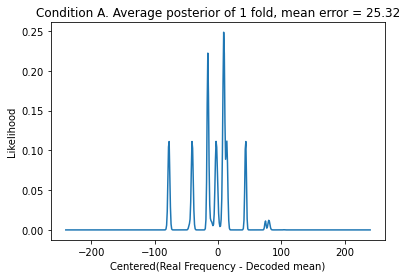

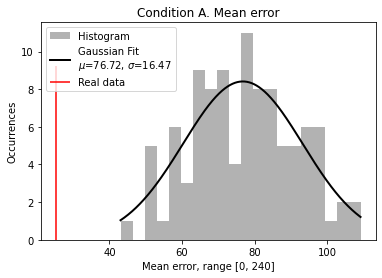

There is decoding for condition A within the 1st percentile


In [18]:
normalized_tag = False # Use True (density=True) for normalized histogram
data = np.mean(mean_error_1st_fold_shuffled, 1)

# Obtained with help from chatGPT
hist_values_1st_fold, bin_edges_1st_fold = np.histogram(data, bins=20, density=normalized_tag)
bin_centers_1st_fold = (bin_edges_1st_fold[:-1] + bin_edges_1st_fold[1:]) / 2  # Compute bin centers

# 3. Initial guess for the Gaussian parameters
amplitude_guess = np.max(hist_values_1st_fold)
mean_guess = np.mean(data)
stddev_guess = np.std(data)
p0 = [amplitude_guess, mean_guess, stddev_guess]

# 4. Fit the Gaussian to the histogram
popt_1st_fold, pcov_1st_fold = curve_fit(gaussian_null_dist, bin_centers_1st_fold, hist_values_1st_fold, p0=p0)
amplitude_1st_fold, mean_1st_fold, stddev_1st_fold = popt_1st_fold


# Plot of the overlayed average posteriors 
plt.plot([i-240 for i in range(481)], new_vector)
label = "Condition "+condition+". Average posterior of 1 fold, mean error = "+str(np.round(np.mean(error_Hz_vec_1st_fold), 2))
plt.title(label)
plt.xlabel("Centered(Real Frequency - Decoded mean)")
plt.ylabel("Likelihood")
plt.show()


# 5. Plot the histogram and the fitted Gaussian
plt.hist(data, bins=20, density=normalized_tag, alpha=0.6, color='gray', label='Histogram')
x_fit = np.linspace(min(data), max(data), 500)  # Smooth x values for plotting
y_fit = gaussian_null_dist(x_fit, amplitude_1st_fold, mean_1st_fold, stddev_1st_fold)  # Fitted Gaussian curve
plt.plot(x_fit, y_fit, color='k', linewidth=2, label=f'Gaussian Fit\n$\mu$={mean_1st_fold:.2f}, $\sigma$={stddev_1st_fold:.2f}')
plt.vlines(np.mean(error_Hz_vec_1st_fold), ymin=0, ymax=np.max(y_fit)*1.1, color="r", label="Real data")
plt.xlabel("Mean error, range [0, 240]")
plt.ylabel("Occurrences")
plt.title("Condition "+condition+". Mean error")
plt.legend()
plt.show()


# Calculating the 5th and 1st percentile of the fitted gaussian to the null distribution
# # Calculating the 5th and 1st percentile
p1_1st_fold = norm.ppf(0.01, loc=mean_1st_fold, scale=stddev_1st_fold)
p5_1st_fold = norm.ppf(0.05, loc=mean_1st_fold, scale=stddev_1st_fold)

# print(f"The 1st percentile on the left side is: {p1_1st_fold:.2f}")

# Is the decoding in the 5th or 1st percentile?
comparison_value = np.mean(error_Hz_vec_1st_fold)

if comparison_value < p5_1st_fold:
    if comparison_value < p1_1st_fold:
        print("There is decoding for condition "+str(condition)+" within the 1st percentile")
    else:
        print("There is decoding for condition "+str(condition)+" within the 5th percentile")
        
else:
    print("The real error is not lower than the 5th percentile of the shuffled distribution.")

Awesome! The decoded error is less than the random permutation of the labels for each voxel's labels which indicate different frequencies.

## Repeat the same procedure (train, decode, shuffle) for for the other fold. Store the data.

### Training the model on the other fold of that condition.

In [19]:
# For every condition, update this cell.
# condition = "A"
# train_matrix = A2[mask_all] # condition_matrix
# test_matrix = A1[mask_all] # matrix

# n_shuffles = 100

# Now,
# condition_matrix -> test_matrix
# matrix -> train_matrix

In [20]:
# Initializing variables
nStimuli = 9
nFolds = 1 # These are the number of overall BOLD coefficients in the big matrix. At least the same as nFolds.
nVoxels = test_matrix.shape[0] # number of voxels

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7

nfrequencies = 241
initial_frequency = 100
print("nVoxels", nVoxels)

B_train = test_matrix.T
B_test = train_matrix.T

# Simulating tactile stimuli
tactile_stimuli = [i*30+initial_frequency for i in range(nStimuli)]
stimuli = np.asarray([tactile_stimuli[i//2] for i in range(len(tactile_stimuli)*2)])

frequency_range = np.arange(initial_frequency, initial_frequency+nfrequencies) # Neurons tuned from 100-340 Hz frequencies


channelBasis, C = create_channel_basis(nChannels, exponent, nStimuli)
print("Data ready.")
W_estimated, B_predicted = model_fit(C, B_train)
print("Model fit ready.")

# Note the model accepts the B matrix where the BOLD coefficients for the same trial
# condition are consecutive. So we have to change the shape of this `m1` and `m2` to satisfy this condition.
# `[B] = nStimuli*nRepeats, nVoxels` alternating the value of one fold with the value for that same trial of the other fold.
# B = np.array([
#     [B_test[i//2][k] if i % 2 == 0 else B_train[i//2][k] for i in range(B_test.shape[0] * 2)]
#     for k in range(B_train.shape[1])]).T
# print(B.shape) # Should be 18*268


C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec_2nd_fold = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)
print("Test ready.")
# initial_plots(B, C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec)
# other_plots(means_vec, sigmas_vec, amplitudes_vec, initial_frequency, probability, tactile_stimuli, average_error_per_condition)

nVoxels 341
Data ready.
Model fit ready.
--- 9.169596910476685 seconds ---
Test ready.


# Shuffling the data

In [21]:
# Test on many shufflings:
mean_error_2nd_fold_shuffled = np.zeros((n_shuffles, 9)) # matrix of n_shuffles and 9 frequencies
error_scalar_normalized_space_vec = np.zeros(n_shuffles)

for k in range(n_shuffles):
    shuffled_matrix = np.zeros(train_matrix.shape)
    
    for i in range (train_matrix.shape[0]):
        shuffled_matrix[i,:] = np.random.permutation(train_matrix[i])

    B_test = shuffled_matrix.T # testVoxelResponse (B2) [txv]

    # Test on shuffled data
    C_estimated, r2, probability, means_vec, sigmas_vec, amplitudes_vec, error_Hz_vec = simulation(B_test, B_predicted, W_estimated, nVoxels, nStimuli, initial_frequency)

    mean_error_2nd_fold_shuffled[k, :] = error_Hz_vec
    print("Done with shuffle "+str(k+1))

--- 9.29032015800476 seconds ---
Done with shuffle 1
--- 9.196436166763306 seconds ---
Done with shuffle 2
--- 9.204346895217896 seconds ---
Done with shuffle 3
--- 9.322063207626343 seconds ---
Done with shuffle 4
--- 9.018726825714111 seconds ---
Done with shuffle 5
--- 9.064602851867676 seconds ---
Done with shuffle 6
--- 9.065299987792969 seconds ---
Done with shuffle 7
--- 9.192701816558838 seconds ---
Done with shuffle 8
--- 9.619179010391235 seconds ---
Done with shuffle 9
--- 12.35392427444458 seconds ---
Done with shuffle 10
--- 12.854618310928345 seconds ---
Done with shuffle 11
--- 14.355098962783813 seconds ---
Done with shuffle 12
--- 12.558304786682129 seconds ---
Done with shuffle 13
--- 13.285727977752686 seconds ---
Done with shuffle 14
--- 12.682624101638794 seconds ---
Done with shuffle 15
--- 12.0706307888031 seconds ---
Done with shuffle 16
--- 13.24039626121521 seconds ---
Done with shuffle 17
--- 14.038152933120728 seconds ---
Done with shuffle 18
--- 13.27877807

### Fitting a gaussian to the null distribution

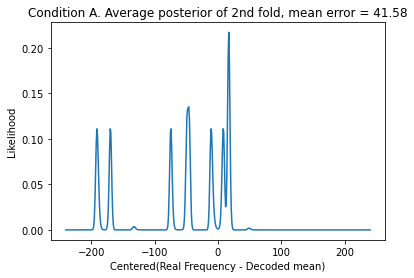

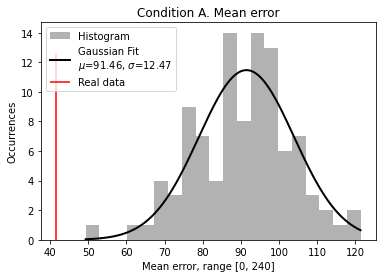

There is decoding for condition A within the 1st percentile


In [22]:
normalized_tag = False # Use True (density=True) for normalized histogram
data = np.mean(mean_error_2nd_fold_shuffled, 1)

# Obtained with help from chatGPT
hist_values_2nd_fold, bin_edges_2nd_fold = np.histogram(data, bins=20, density=normalized_tag)
bin_centers_2nd_fold = (bin_edges_2nd_fold[:-1] + bin_edges_2nd_fold[1:]) / 2  # Compute bin centers

# 3. Initial guess for the Gaussian parameters
amplitude_guess = np.max(hist_values_2nd_fold)
mean_guess = np.mean(data)
stddev_guess = np.std(data)
p0 = [amplitude_guess, mean_guess, stddev_guess]

# 4. Fit the Gaussian to the histogram
popt_2nd_fold, pcov_2nd_fold = curve_fit(gaussian_null_dist, bin_centers_2nd_fold, hist_values_2nd_fold, p0=p0)
amplitude_2nd_fold, mean_2nd_fold, stddev_2nd_fold = popt_2nd_fold


# Visualization of overlayed likelihoods
# Data for the average posterior plot
frequencies_n = 9
new_vector = np.zeros(481)

for freq_i in range(frequencies_n):
    offset = 240 - tactile_stimuli[freq_i] + 100
    new_vector[offset:offset+241] = new_vector[offset:offset+241] + probability[freq_i,:]

new_vector = new_vector/frequencies_n

plt.plot([i-240 for i in range(481)], new_vector)
label = "Condition "+condition+". Average posterior of 2nd fold, mean error = "+str(np.round(np.mean(error_Hz_vec_2nd_fold), 2))
plt.title(label)
plt.xlabel("Centered(Real Frequency - Decoded mean)")
plt.ylabel("Likelihood")
plt.show()

# 5. Plot the histogram and the fitted Gaussian
plt.hist(data, bins=20, density=normalized_tag, alpha=0.6, color='gray', label='Histogram')
x_fit = np.linspace(min(data), max(data), 500)  # Smooth x values for plotting
y_fit = gaussian_null_dist(x_fit, amplitude_2nd_fold, mean_2nd_fold, stddev_2nd_fold)  # Fitted Gaussian curve
plt.plot(x_fit, y_fit, color='k', linewidth=2, label=f'Gaussian Fit\n$\mu$={mean_2nd_fold:.2f}, $\sigma$={stddev_2nd_fold:.2f}')
plt.vlines(np.mean(error_Hz_vec_2nd_fold), ymin=0, ymax=np.max(y_fit)*1.1, color="r", label="Real data")
plt.xlabel("Mean error, range [0, 240]")
plt.ylabel("Occurrences")
plt.title("Condition "+condition+". Mean error")
plt.legend()
plt.show()


# Calculating the 5th and 1st percentile of the fitted gaussian to the null distribution
# # Calculating the 5th and 1st percentile
p1_2nd_fold = norm.ppf(0.01, loc=mean_2nd_fold, scale=stddev_2nd_fold)
p5_2nd_fold = norm.ppf(0.05, loc=mean_2nd_fold, scale=stddev_2nd_fold)

# print(f"The 1st percentile on the left side is: {p1_1st_fold:.2f}")

# Is the decoding in the 5th or 1st percentile?
comparison_value = np.mean(error_Hz_vec_2nd_fold)

if comparison_value < p5_2nd_fold:
    if comparison_value < p1_2nd_fold:
        print("There is decoding for condition "+str(condition)+" within the 1st percentile")
    else:
        print("There is decoding for condition "+str(condition)+" within the 5th percentile")
        
else:
    print("The real error is not lower than the 5th percentile of the shuffled distribution.")

# Averaging across the 2 sets of values, that is, across error sets of 18 values.
### Plot the new null distribution and where the real values lie in there.

In [23]:
# Obtain the average across 18 values
error_real = np.mean([error_Hz_vec_1st_fold, error_Hz_vec_2nd_fold])

errors_shuffled = np.zeros(n_shuffles)
# Now, build the null distribution
# mean_error_vec_A2shuffled and mean_error_vec_A1shuffled
for i in range(n_shuffles):
    errors_shuffled[i] = np.mean([mean_error_1st_fold_shuffled[i,:], mean_error_2nd_fold_shuffled[i,:]])
    
    
# Fitting a gaussian to these error_shuffled values.
normalized_tag = False # Use True (density=True) for normalized histogram
data = errors_shuffled

# Obtained with help from chatGPT
hist_values, bin_edges = np.histogram(data, bins=20, density=normalized_tag)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

# 3. Initial guess for the Gaussian parameters
amplitude_guess = np.max(hist_values)
mean_guess = np.mean(data)
stddev_guess = np.std(data)
p0 = [amplitude_guess, mean_guess, stddev_guess]

# 4. Fit the Gaussian to the histogram
popt, pcov = curve_fit(gaussian_null_dist, bin_centers, hist_values, p0=p0)
amplitude, mean, stddev = popt


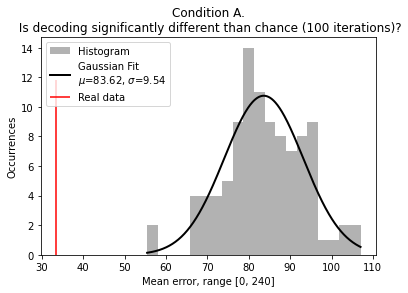

There is decoding for condition A within the 1st percentile


In [24]:
# plt.hist(errors_shuffled, bins=10, label="Distribution of shuffled data")
# plt.vlines(error_real, ymin=0, ymax=n_shuffles/3, color="r", label="Real error")
title_line = "Condition "+condition+".\n Is decoding significantly different than chance ("+str(n_shuffles)+" iterations)?"

plt.hist(data, bins=20, density=normalized_tag, alpha=0.6, color='gray', label='Histogram')
x_fit = np.linspace(min(data), max(data), 500)  # Smooth x values for plotting
y_fit = gaussian_null_dist(x_fit, amplitude, mean, stddev)  # Fitted Gaussian curve
plt.plot(x_fit, y_fit, color='k', linewidth=2, label=f'Gaussian Fit\n$\mu$={mean:.2f}, $\sigma$={stddev:.2f}')
plt.vlines(error_real, ymin=0, ymax=np.max(y_fit)*1.1, color="r", label="Real data")
plt.xlabel("Mean error, range [0, 240]")
plt.ylabel("Occurrences")
plt.title(title_line)
plt.legend(loc="upper left")
plt.show()


# Calculating the 5th and 1st percentile of the fitted gaussian to the null distribution
p1 = norm.ppf(0.01, loc=mean, scale=stddev)
p5 = norm.ppf(0.05, loc=mean, scale=stddev)

# Is the decoding in the 5th or 1st percentile?
comparison_value = np.mean(error_real)

if comparison_value < p5:
    if comparison_value < p1:
        print("There is decoding for condition "+str(condition)+" within the 1st percentile")
    else:
        print("There is decoding for condition "+str(condition)+" within the 5th percentile")
        
else:
    print("The real error is not lower than the 5th percentile of the shuffled distribution.")